In [1]:
import csv
import itertools
from matplotlib import pyplot as plt
import numpy as np
import random

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import warnings
# warnings.filterwarnings("ignore")

/usr/local/lib/python3.5/dist-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### Read the data

Note about the data: The dataset is rather large, and very skewed toward valid transactions. To balance it a bit better, we sample and only keep around 5% of the valid transactions

In [2]:
with open('creditcard.csv', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    csv_data = list(reader)[1:]
    
csv_data = [row for row in csv_data if int(row[-1]) == 1 or random.random() < .05]

# Format: Time, V1, ..., V28, Amount, Class
data = np.array([[float(x) for x in row[1:-1]] for row in csv_data])
times = np.array([float(row[0]) for row in csv_data])
labels = np.array([int(row[-1]) for row in csv_data])
print('The data is imbalanced, with {} samples in total but only {} cases of fraud'.format(len(labels), sum(labels)))

The data is imbalanced, with 14742 samples in total but only 492 cases of fraud


### Feature Scaling

In [3]:
print(np.mean(data, axis=0))
print(np.var(data, axis=0))
print('The PCA features have mean 0 but different variances')
print('The transaction amount is not scaled. We should scale it so it does not affect the SVM too much')

[ -1.33623696e-01   1.34958712e-01  -2.19303376e-01   1.42990527e-01
  -8.87207030e-02  -4.67978231e-02  -1.84337979e-01   7.81799415e-03
  -7.68847371e-02  -1.87744222e-01   1.22943822e-01  -1.98219881e-01
  -1.63187127e-03  -2.19910713e-01  -1.79715360e-02  -1.35634158e-01
  -2.04638842e-01  -7.89252701e-02   2.61330457e-02   2.03630969e-02
   2.56398914e-02  -5.79213680e-03  -1.03593629e-02  -2.18409246e-04
   3.67230821e-03  -1.33938396e-03   6.74809001e-03   6.97794763e-04
   8.72831773e+01]
[  5.61367957e+00   3.26149945e+00   5.31663980e+00   2.81387136e+00
   3.05182033e+00   1.83926563e+00   4.04029209e+00   2.91251034e+00
   1.58221236e+00   2.88435862e+00   1.66087771e+00   2.86453798e+00
   1.00903437e+00   2.97845191e+00   8.61979135e-01   1.74013316e+00
   3.61505837e+00   1.10070222e+00   7.18872855e-01   4.87678928e-01
   1.04127943e+00   5.76731618e-01   4.72718665e-01   3.60950178e-01
   2.80235406e-01   2.28475042e-01   1.98370371e-01   9.30734218e-02
   5.35164606e+

In [4]:
scaler = StandardScaler()
data_sc = scaler.fit_transform(data)
print(np.mean(data_sc, axis=0))
print(np.var(data_sc, axis=0))

[  3.93947676e-17   2.09823642e-17   1.99700067e-16  -4.74177519e-16
  -5.99845773e-16   4.35594219e-17   3.93684090e-16   2.27241009e-16
  -2.09309649e-16   6.59265524e-17   2.88106716e-16  -1.19585073e-16
  -8.77363874e-19   1.01062151e-15  -3.13320572e-16   2.19374858e-16
   5.50781176e-17  -9.16769939e-16  -1.26355460e-16  -1.40058152e-16
  -1.07432830e-16  -7.98438781e-17   1.25786868e-16   6.68302749e-17
  -1.43857551e-16   1.99368703e-16   1.31777795e-16  -5.29807284e-18
   9.05117944e-15]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


### Preliminary plotting

[ 0.69488478  1.16661638 -0.71476402  1.00658858  0.95960166  0.29850317
  0.92599661 -0.65526428 -5.28597051]


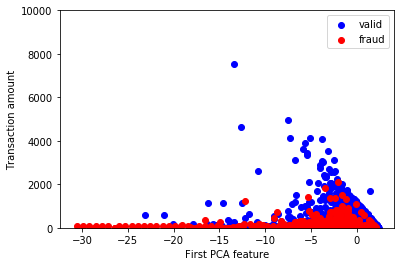

In [5]:
# plot the first two principal components
data_fraud = data[np.where(labels == 1)]
data_valid = data[np.where(labels == 0)]
plt.scatter(data_valid[:, 0], data_valid[:, -1], c='b')
plt.scatter(data_fraud[:, 0], data_fraud[:, -1], c='r')
print(data_valid[1:10, 0])
plt.ylim((0, 10000))
plt.legend(['valid', 'fraud'])
plt.xlabel('First PCA feature')
plt.ylabel('Transaction amount')
plt.show()

### Setting up cross-validation

In [6]:
fraud_indices = np.where(labels == 1)[0]
np.random.shuffle(fraud_indices)
fraud_splits = np.array_split(fraud_indices, 5)

valid_indices = np.where(labels == 0)[0]
np.random.shuffle(valid_indices)
valid_splits = np.array_split(valid_indices, 5)

folds = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits, valid_splits)]

### SVM

In [7]:
def train_binary_SVM(data, scale=False, kernel=None, class_weight=None):
    confusion_mat = np.zeros((2, 2))
    for i in range(5):
        if kernel is None:
            if class_weight is None:
                svm = LinearSVC(fit_intercept=False, dual=False)
            else:
                svm = LinearSVC(fit_intercept=False, dual=False, class_weight=class_weight)
        else:
            if class_weight is None:
                svm = SVC(kernel=kernel, gamma='auto')
            else:
                svm = SVC(kernel=kernel, gamma='auto', class_weight=class_weight)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        svm.fit(train_data, np.delete(labels, folds[i]))
        pred = svm.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        print('Fold', i)
        print(conf_mat)

        confusion_mat += conf_mat

    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    print('False positives (wrongly flagged):\t', confusion_mat[0, 1] / sum(confusion_mat[0, :]))
    print('False negatives (missed fraud):\t\t', confusion_mat[1, 0] / sum(confusion_mat[1,:]))
    fscore = 2*confusion_mat[1,1] / (2*confusion_mat[1,1] + confusion_mat[0,1] + confusion_mat[1,0])
    print('F-score: {}'.format(fscore))
    return confusion_mat

#### Linear SVM -- Without scaling or class weights

In [8]:
train_binary_SVM(data);

Fold 0
[[2843    7]
 [  20   79]]
Fold 1
[[2841    9]
 [  22   77]]
Fold 2
[[2831   19]
 [  11   87]]
Fold 3
[[2844    6]
 [  23   75]]
Fold 4
[[2841    9]
 [  26   72]]
Final Confusion Matrix
[[ 2840.     10. ]
 [   20.4    78. ]]
False positives (wrongly flagged):	 0.00350877192982
False negatives (missed fraud):		 0.207317073171
F-score: 0.8369098712446351


#### Linear SVM with Scaling

In [9]:
train_binary_SVM(data, scale=True);

Fold 0
[[2849    1]
 [  19   80]]
Fold 1
[[2848    2]
 [  20   79]]
Fold 2
[[2848    2]
 [   9   89]]
Fold 3
[[2849    1]
 [  17   81]]
Fold 4
[[2847    3]
 [  25   73]]
Final Confusion Matrix
[[  2.84820000e+03   1.80000000e+00]
 [  1.80000000e+01   8.04000000e+01]]
False positives (wrongly flagged):	 0.000631578947368
False negatives (missed fraud):		 0.182926829268
F-score: 0.8903654485049833


#### Linear SVM with Scaling and Class Weights

In [10]:
train_binary_SVM(data, scale=True, class_weight='balanced');

Fold 0
[[2743  107]
 [  10   89]]
Fold 1
[[2772   78]
 [   9   90]]
Fold 2
[[2753   97]
 [   4   94]]
Fold 3
[[2762   88]
 [   9   89]]
Fold 4
[[2771   79]
 [  12   86]]
Final Confusion Matrix
[[ 2760.2    89.8]
 [    8.8    89.6]]
False positives (wrongly flagged):	 0.0315087719298
False negatives (missed fraud):		 0.0894308943089
F-score: 0.6450683945284377


### Kernel SVM

#### RBF Kernel with Scaling and Class Weights

In [11]:
train_binary_SVM(data, scale=True, kernel='rbf');

Fold 0
[[2850    0]
 [  24   75]]
Fold 1
[[2850    0]
 [  23   76]]
Fold 2
[[2847    3]
 [  14   84]]
Fold 3
[[2850    0]
 [  22   76]]
Fold 4
[[2847    3]
 [  29   69]]
Final Confusion Matrix
[[  2.84880000e+03   1.20000000e+00]
 [  2.24000000e+01   7.60000000e+01]]
False positives (wrongly flagged):	 0.000421052631579
False negatives (missed fraud):		 0.227642276423
F-score: 0.8656036446469249


In [12]:
train_binary_SVM(data, kernel='rbf', class_weight='balanced');

Fold 0
[[2841    9]
 [  42   57]]
Fold 1
[[2841    9]
 [  43   56]]
Fold 2
[[2836   14]
 [  39   59]]
Fold 3
[[2835   15]
 [  54   44]]
Fold 4
[[2833   17]
 [  55   43]]
Final Confusion Matrix
[[ 2837.2    12.8]
 [   46.6    51.8]]
False positives (wrongly flagged):	 0.00449122807018
False negatives (missed fraud):		 0.473577235772
F-score: 0.6355828220858896


#### Polynomial Kernel with Scaling and Class Weights

In [13]:
train_binary_SVM(data, scale=True, kernel='poly');

Fold 0
[[2846    4]
 [  19   80]]
Fold 1
[[2848    2]
 [  22   77]]
Fold 2
[[2843    7]
 [   8   90]]
Fold 3
[[2849    1]
 [  16   82]]
Fold 4
[[2846    4]
 [  23   75]]
Final Confusion Matrix
[[ 2846.4     3.6]
 [   17.6    80.8]]
False positives (wrongly flagged):	 0.00126315789474
False negatives (missed fraud):		 0.178861788618
F-score: 0.8840262582056894


In [14]:
train_binary_SVM(data, scale=True, kernel='poly', class_weight='balanced');

Fold 0
[[2830   20]
 [  16   83]]
Fold 1
[[2837   13]
 [  19   80]]
Fold 2
[[2828   22]
 [  10   88]]
Fold 3
[[2830   20]
 [  14   84]]
Fold 4
[[2828   22]
 [  18   80]]
Final Confusion Matrix
[[ 2830.6    19.4]
 [   15.4    83. ]]
False positives (wrongly flagged):	 0.00680701754386
False negatives (missed fraud):		 0.156504065041
F-score: 0.8266932270916334


Interestingly, balanced weights peform worse than only using scaled data. The balanced weights overcompensate too much.
Simply scaling the data works best, with the linear and polynomial kernels

### Logistic Regression

In [15]:
def train_logistic_regression(data, folds, labels, class_weight = None, C=1.0):
    err = 0
    err_valid = 0
    err_fraud = 0
    confusion_mat = np.zeros((2, 2))
    AU = 0
    for i in range(5):
        model = LogisticRegression(class_weight=class_weight, C=C)
        
        model.fit(np.delete(data, folds[i], axis=0), np.delete(labels, folds[i]))
        pred = model.predict(data[folds[i]])
        pred1 = model.predict_proba(data[folds[i]])[:,1]
        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred1)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        #print('Fold', i)
        #print(conf_mat)
        #print('Area under curve:', area_under_curve)

        confusion_mat += conf_mat
    AU/=5
    confusion_mat /= 5
    print('Final Confusion Matrix')
    print(confusion_mat)
    return confusion_mat, AU

#### Logistic Regression with Scaling, Class Weights, and Regularization

In [16]:
weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc, folds, labels, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[  2.84860000e+03   1.40000000e+00]
 [  1.80000000e+01   8.04000000e+01]]
F1 score: 0.892341842397
Recall: 0.817073170732
Precision: 0.982885085575
AUC: 0.97998394254
Checking class weight None and coefficient 0.016681005372000592


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[  2.84860000e+03   1.40000000e+00]
 [  1.74000000e+01   8.10000000e+01]]
F1 score: 0.896017699115
Recall: 0.823170731707
Precision: 0.983009708738
AUC: 0.980289128304
Checking class weight None and coefficient 0.027825594022071243


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[  2.84860000e+03   1.40000000e+00]
 [  1.72000000e+01   8.12000000e+01]]
F1 score: 0.897237569061
Recall: 0.825203252033
Precision: 0.983050847458
AUC: 0.98061674388
Checking class weight None and coefficient 0.046415888336127774


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[  2.84860000e+03   1.40000000e+00]
 [  1.76000000e+01   8.08000000e+01]]
F1 score: 0.894795127353
Recall: 0.821138211382
Precision: 0.98296836983
AUC: 0.980836015001
Checking class weight None and coefficient 0.0774263682681127


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[  2.84840000e+03   1.60000000e+00]
 [  1.76000000e+01   8.08000000e+01]]
F1 score: 0.893805309735
Recall: 0.821138211382
Precision: 0.980582524272
AUC: 0.980966434846
Checking class weight None and coefficient 0.1291549665014884


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[  2.84800000e+03   2.00000000e+00]
 [  1.74000000e+01   8.10000000e+01]]
F1 score: 0.893054024256
Recall: 0.823170731707
Precision: 0.975903614458
AUC: 0.980863558608
Checking class weight None and coefficient 0.21544346900318834


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[  2.84800000e+03   2.00000000e+00]
 [  1.74000000e+01   8.10000000e+01]]
F1 score: 0.893054024256
Recall: 0.823170731707
Precision: 0.975903614458
AUC: 0.980669270579
Checking class weight None and coefficient 0.3593813663804626


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[  2.84780000e+03   2.20000000e+00]
 [  1.72000000e+01   8.12000000e+01]]
F1 score: 0.893289328933
Recall: 0.825203252033
Precision: 0.973621103118
AUC: 0.980445536641
Checking class weight None and coefficient 0.5994842503189409


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[  2.84780000e+03   2.20000000e+00]
 [  1.70000000e+01   8.14000000e+01]]
F1 score: 0.894505494505
Recall: 0.827235772358
Precision: 0.973684210526
AUC: 0.980111982698
Checking class weight None and coefficient 1.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[  2.84760000e+03   2.40000000e+00]
 [  1.70000000e+01   8.14000000e+01]]
F1 score: 0.893523600439
Recall: 0.827235772358
Precision: 0.971360381862
AUC: 0.979787976435
Checking class weight balanced and coefficient 0.01


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[ 2788.6    61.4]
 [    9.6    88.8]]
F1 score: 0.714400643604
Recall: 0.90243902439
Precision: 0.59121171771
AUC: 0.979745590528
Checking class weight balanced and coefficient 0.016681005372000592


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 2785.8    64.2]
 [    9.6    88.8]]
F1 score: 0.706443914081
Recall: 0.90243902439
Precision: 0.580392156863
AUC: 0.97957513553
Checking class weight balanced and coefficient 0.027825594022071243


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[ 2784.4    65.6]
 [    9.4    89. ]]
F1 score: 0.703557312253
Recall: 0.904471544715
Precision: 0.575679172057
AUC: 0.97933798421
Checking class weight balanced and coefficient 0.046415888336127774


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 2782.4    67.6]
 [    9.4    89. ]]
F1 score: 0.698039215686
Recall: 0.904471544715
Precision: 0.568326947637
AUC: 0.979098612332
Checking class weight balanced and coefficient 0.0774263682681127


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[ 2782.4    67.6]
 [    9.4    89. ]]
F1 score: 0.698039215686
Recall: 0.904471544715
Precision: 0.568326947637
AUC: 0.978860838966
Checking class weight balanced and coefficient 0.1291549665014884


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 2782.2    67.8]
 [    9.     89.4]]
F1 score: 0.699530516432
Recall: 0.908536585366
Precision: 0.568702290076
AUC: 0.978663339445
Checking class weight balanced and coefficient 0.21544346900318834


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[ 2782.8    67.2]
 [    9.     89.4]]
F1 score: 0.701176470588
Recall: 0.908536585366
Precision: 0.570881226054
AUC: 0.978509498855
Checking class weight balanced and coefficient 0.3593813663804626


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 2782.8    67.2]
 [    9.     89.4]]
F1 score: 0.701176470588
Recall: 0.908536585366
Precision: 0.570881226054
AUC: 0.978436224038
Checking class weight balanced and coefficient 0.5994842503189409


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Final Confusion Matrix
[[ 2783.4    66.6]
 [    9.     89.4]]
F1 score: 0.702830188679
Recall: 0.908536585366
Precision: 0.573076923077
AUC: 0.978384127707
Checking class weight balanced and coefficient 1.0


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 2783.8    66.2]
 [    9.     89.4]]
F1 score: 0.703937007874
Recall: 0.908536585366
Precision: 0.574550128535
AUC: 0.978344381878
Best parameters found for Logistic Regression under AUC metric is None class weights and 0.0774263682681127 coefficient
Best parameters found for Logistic Regression under F1 metric is None class weights and 0.01 coefficient
Best parameters found for Logistic Regression under precision metric is None class weights and 0.027825594022071243 coefficient
Best parameters found for Logistic Regression under recall metric is balanced class weights and 0.1291549665014884 coefficient


Notice how when using balanced class weights, the metric of precision is thrown off since while there is a small false positive rate, the difference in size of the two distributions cause false positives to be on at least the same order of magnitude as the true positives. We can rectify this by downsampling until the two classes have around equal representation.

In [17]:
#Notice that if we fully downsample the dataset so that valid and fraud are equally represented, we have much more consistent metrics.
#Then we see that the recommended parameters begin to converge.

csv_data2 = [row for row in csv_data if int(row[-1]) == 1 or random.random() < 0.00164/.05]

# Find new splits for resampled data
data2 = np.array([[float(x) for x in row[1:-1]] for row in csv_data2])
times2 = np.array([float(row[0]) for row in csv_data2])
labels2 = np.array([int(row[-1]) for row in csv_data2])

data_sc2 = scaler.fit_transform(data2)

fraud_indices2 = np.where(labels2 == 1)[0]
np.random.shuffle(fraud_indices2)
fraud_splits2 = np.array_split(fraud_indices2, 5)

valid_indices2 = np.where(labels2 == 0)[0]
np.random.shuffle(valid_indices2)
valid_splits2 = np.array_split(valid_indices2, 5)

folds2 = [np.concatenate((fraud_sp, valid_sp)) for fraud_sp, valid_sp in zip(fraud_splits2, valid_splits2)]

weights = [None,'balanced']
coefficients = np.logspace(-2,0,10)
fscore = []
recall = []
precision = []
AU = []
param_permuations = list(itertools.product(weights, coefficients))
for cw,C in param_permuations:
    print('Checking class weight {} and coefficient {}'.format(cw, C))
    cf,au = train_logistic_regression(data_sc2, folds2, labels2, cw, C)
    TP = cf[1][1]
    FP = cf[0][1]
    FN = cf[1][0]
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    f1 = prec*rec*2/(prec+rec)
    print('F1 score:', f1)
    print('Recall:', rec)
    print('Precision:', prec)
    print('AUC:', au)
    fscore.append(f1)
    recall.append(rec)
    precision.append(prec)
    AU.append(au)

idx = np.argmax(AU)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under AUC metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(f1)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under F1 metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(precision)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under precision metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

idx = np.argmax(recall)
best_params = param_permuations[idx]
print('Best parameters found for Logistic Regression under recall metric is {} class weights and {} coefficient'.format(best_params[0], best_params[1]))

Checking class weight None and coefficient 0.01
Final Confusion Matrix
[[ 96.4   0.2]
 [ 18.6  79.8]]
F1 score: 0.894618834081
Recall: 0.810975609756
Precision: 0.9975
AUC: 0.976803937758
Checking class weight None and coefficient 0.016681005372000592
Final Confusion Matrix
[[ 96.4   0.2]
 [ 18.   80.4]]
F1 score: 0.898324022346
Recall: 0.817073170732
Precision: 0.997518610422
AUC: 0.977475961487
Checking class weight None and coefficient 0.027825594022071243
Final Confusion Matrix
[[ 96.    0.6]
 [ 16.2  82.2]]
F1 score: 0.907284768212
Recall: 0.835365853659
Precision: 0.992753623188
AUC: 0.977872507954
Checking class weight None and coefficient 0.046415888336127774
Final Confusion Matrix
[[ 95.8   0.8]
 [ 14.4  84. ]]
F1 score: 0.917030567686
Recall: 0.853658536585
Precision: 0.990566037736
AUC: 0.977847576863
Checking class weight None and coefficient 0.0774263682681127
Final Confusion Matrix
[[ 95.4   1.2]
 [ 13.   85.4]]
F1 score: 0.923243243243
Recall: 0.867886178862
Precision: 0

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 94.6   2. ]
 [ 11.2  87.2]]
F1 score: 0.929637526652
Recall: 0.886178861789
Precision: 0.977578475336
AUC: 0.977331847297
Checking class weight None and coefficient 0.5994842503189409
Final Confusion Matrix
[[ 94.4   2.2]
 [ 10.8  87.6]]
F1 score: 0.930924548353
Recall: 0.890243902439
Precision: 0.975501113586
AUC: 0.977035337331
Checking class weight None and coefficient 1.0
Final Confusion Matrix
[[ 94.    2.6]
 [ 10.4  88. ]]
F1 score: 0.931216931217
Recall: 0.894308943089
Precision: 0.971302428256
AUC: 0.976781975286
Checking class weight balanced and coefficient 0.01
Final Confusion Matrix
[[ 96.4   0.2]
 [ 19.   79.4]]
F1 score: 0.892134831461
Recall: 0.806910569106
Precision: 0.997487437186
AUC: 0.976804369436
Checking class weight balanced and coefficient 0.016681005372000592
Final Confusion Matrix
[[ 96.4   0.2]
 [ 18.   80.4]]
F1 score: 0.898324022346
Recall: 0.817073170732
Precision: 0.997518610422
AUC: 0.977475748969
Checking class weight balanced 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 95.8   0.8]
 [ 14.4  84. ]]
F1 score: 0.917030567686
Recall: 0.853658536585
Precision: 0.990566037736
AUC: 0.977847576863
Checking class weight balanced and coefficient 0.0774263682681127
Final Confusion Matrix
[[ 95.4   1.2]
 [ 13.   85.4]]
F1 score: 0.923243243243
Recall: 0.867886178862
Precision: 0.986143187067
AUC: 0.978118544747
Checking class weight balanced and coefficient 0.1291549665014884
Final Confusion Matrix
[[ 95.4   1.2]
 [ 12.   86.4]]
F1 score: 0.929032258065
Recall: 0.878048780488
Precision: 0.986301369863
AUC: 0.977694058723
Checking class weight balanced and coefficient 0.21544346900318834
Final Confusion Matrix
[[ 95.4   1.2]
 [ 11.2  87.2]]
F1 score: 0.933618843683
Recall: 0.886178861789
Precision: 0.986425339367
AUC: 0.977355005185
Checking class weight balanced and coefficient 0.3593813663804626
Final Confusion Matrix
[[ 94.6   2. ]
 [ 11.2  87.2]]
F1 score: 0.929637526652
Recall: 0.886178861789
Precision: 0.977578475336
AUC: 0.97735267

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Final Confusion Matrix
[[ 94.4   2.2]
 [ 10.4  88. ]]
F1 score: 0.933191940615
Recall: 0.894308943089
Precision: 0.975609756098
AUC: 0.976782406965
Best parameters found for Logistic Regression under AUC metric is None class weights and 0.0774263682681127 coefficient
Best parameters found for Logistic Regression under F1 metric is None class weights and 0.01 coefficient
Best parameters found for Logistic Regression under precision metric is None class weights and 0.016681005372000592 coefficient
Best parameters found for Logistic Regression under recall metric is None class weights and 1.0 coefficient


In these cases, the balanced and None class weights perform around the same as expected. However, we can see that the issue with precision and F1 score is fixed. Thus, we advise caution simply using balanced class weights and just looking at the statistics.

# kNN

In [18]:
def train_KNN(data, k, scale=False):
    confusion_mat = np.zeros((2, 2))
    AU = 0
    errors = 0
    for i in range(5):
        knn = KNeighborsClassifier(n_neighbors=k)
        
        train_data = np.delete(data, folds[i], axis=0)
        test_data = data[folds[i]]
        if scale:
            scaler = StandardScaler()
            train_data = scaler.fit_transform(train_data)
            test_data = scaler.transform(test_data)

        knn.fit(train_data, np.delete(labels, folds[i]))
        pred = knn.predict(test_data)

        conf_mat = confusion_matrix(labels[folds[i]], pred)
        fpr, tpr, thresholds = roc_curve(labels[folds[i]], pred)
        area_under_curve = auc(fpr, tpr)
        AU += area_under_curve
        err = sum([1 if a != b else 0 for a, b in zip(labels[folds[i]], pred)]) / len(pred)
        errors += err

        confusion_mat += conf_mat

    confusion_mat /= 5
    AU /= 5
    errors /= 5
    return confusion_mat, AU, errors

In [19]:
fscores = []
Ks = [1, 3, 5, 7, 9, 11]
for k in Ks:
    conf, au, errors = train_KNN(data, k)
    print('K = {}, errors = {}'.format(k, errors))
    print('Confusion Matrix:')
    print(conf)
    fnr = conf[0, 1] / sum(conf[0, :])
    fpr = conf[1, 0] / sum(conf[1,:])
    print('False Negative Rate: {:3f}\nFalse Positive Rate: {:3f}'.format(fnr, fpr))
    fscore = 2*conf[1,1] / (2*conf[1,1] + conf[0,1] + conf[1,0])
    print('fscore: {}'.format(fscore))
    fscores.append(fscore)
    print()
    
opt_ind = np.argmax(fscores)
k_opt = Ks[opt_ind]
print('The optimal K is {} with fscore {}'.format(k_opt, fscores[opt_ind]))

K = 1, errors = 0.01017514848765513
Confusion Matrix:
[[ 2840.2     9.8]
 [   20.2    78.2]]
False Negative Rate: 0.003439
False Positive Rate: 0.205285
fscore: 0.8390557939914163

K = 3, errors = 0.0092933326523767
Confusion Matrix:
[[  2.84740000e+03   2.60000000e+00]
 [  2.48000000e+01   7.36000000e+01]]
False Negative Rate: 0.000912
False Positive Rate: 0.252033
fscore: 0.843069873997709

K = 5, errors = 0.009768230888468964
Confusion Matrix:
[[  2.84800000e+03   2.00000000e+00]
 [  2.68000000e+01   7.16000000e+01]]
False Negative Rate: 0.000702
False Positive Rate: 0.272358
fscore: 0.8325581395348837

K = 7, errors = 0.010785708928767795
Confusion Matrix:
[[  2.84840000e+03   1.60000000e+00]
 [  3.02000000e+01   6.82000000e+01]]
False Negative Rate: 0.000561
False Positive Rate: 0.306911
fscore: 0.8109393579072534

K = 9, errors = 0.011735482395660649
Confusion Matrix:
[[  2.84840000e+03   1.60000000e+00]
 [  3.30000000e+01   6.54000000e+01]]
False Negative Rate: 0.000561
False Po